In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import os
import random
from tensorflow.keras.models import load_model
from scipy.ndimage import zoom

In [12]:
# Change the paths so it fits your local directory

img_dir = "/Users/jesselemeer/Documents/GitHub/quality-control/linsen_data/test/not-good"
model_path = "/Users/jesselemeer/Documents/GitHub/quality-control/models/CNN/SR_FourthTry_DataAug_OptParam_BW2_Dropout0.6_L-Data_512_E24.keras"
layer_name = 'conv2d_44' 
dense_layer = 'dense_29'

num_pics = 5

In [3]:
def do_heatmap(img_path,model,layer_name, dense_layer):
    
    img = image.load_img(img_path, target_size=(512, 512))  # Adjust target_size as per model input
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0  # normalisation

    prediction = model.predict(x)
    print(prediction)

    last_conv_layer = model.get_layer(layer_name).output
    pred_layer = model.get_layer(dense_layer).output
    intermediate_layer_model = tf.keras.models.Model(model.inputs, outputs=[last_conv_layer, pred_layer])
    
    conv,pred = intermediate_layer_model.predict(x)

    target = np.argmax(pred, axis=1).squeeze()
    w, b = intermediate_layer_model.get_layer(dense_layer).weights
    weight = w[:, target].numpy()

    heatmap = conv.squeeze(axis=0) 
    heatmap_2d = np.mean(heatmap, axis=-1)  

    scale_x = 512 / heatmap_2d.shape[1]
    scale_y = 512 / heatmap_2d.shape[0]
    heatmap_scaled = zoom(heatmap_2d, zoom=(scale_y, scale_x))
    
    return img, heatmap_scaled, prediction[0][0]

1/1 [==============================] - 0s 152ms/step
[[0.85677457]]
1/1 [==============================] - 0s 47ms/step
[[0.99985707]]
1/1 [==============================] - 0s 42ms/step
[[0.68966776]]
1/1 [==============================] - 0s 40ms/step
[[0.9501394]]
1/1 [==============================] - 0s 40ms/step
[[0.98990947]]
1/1 [==============================] - 0s 87ms/step


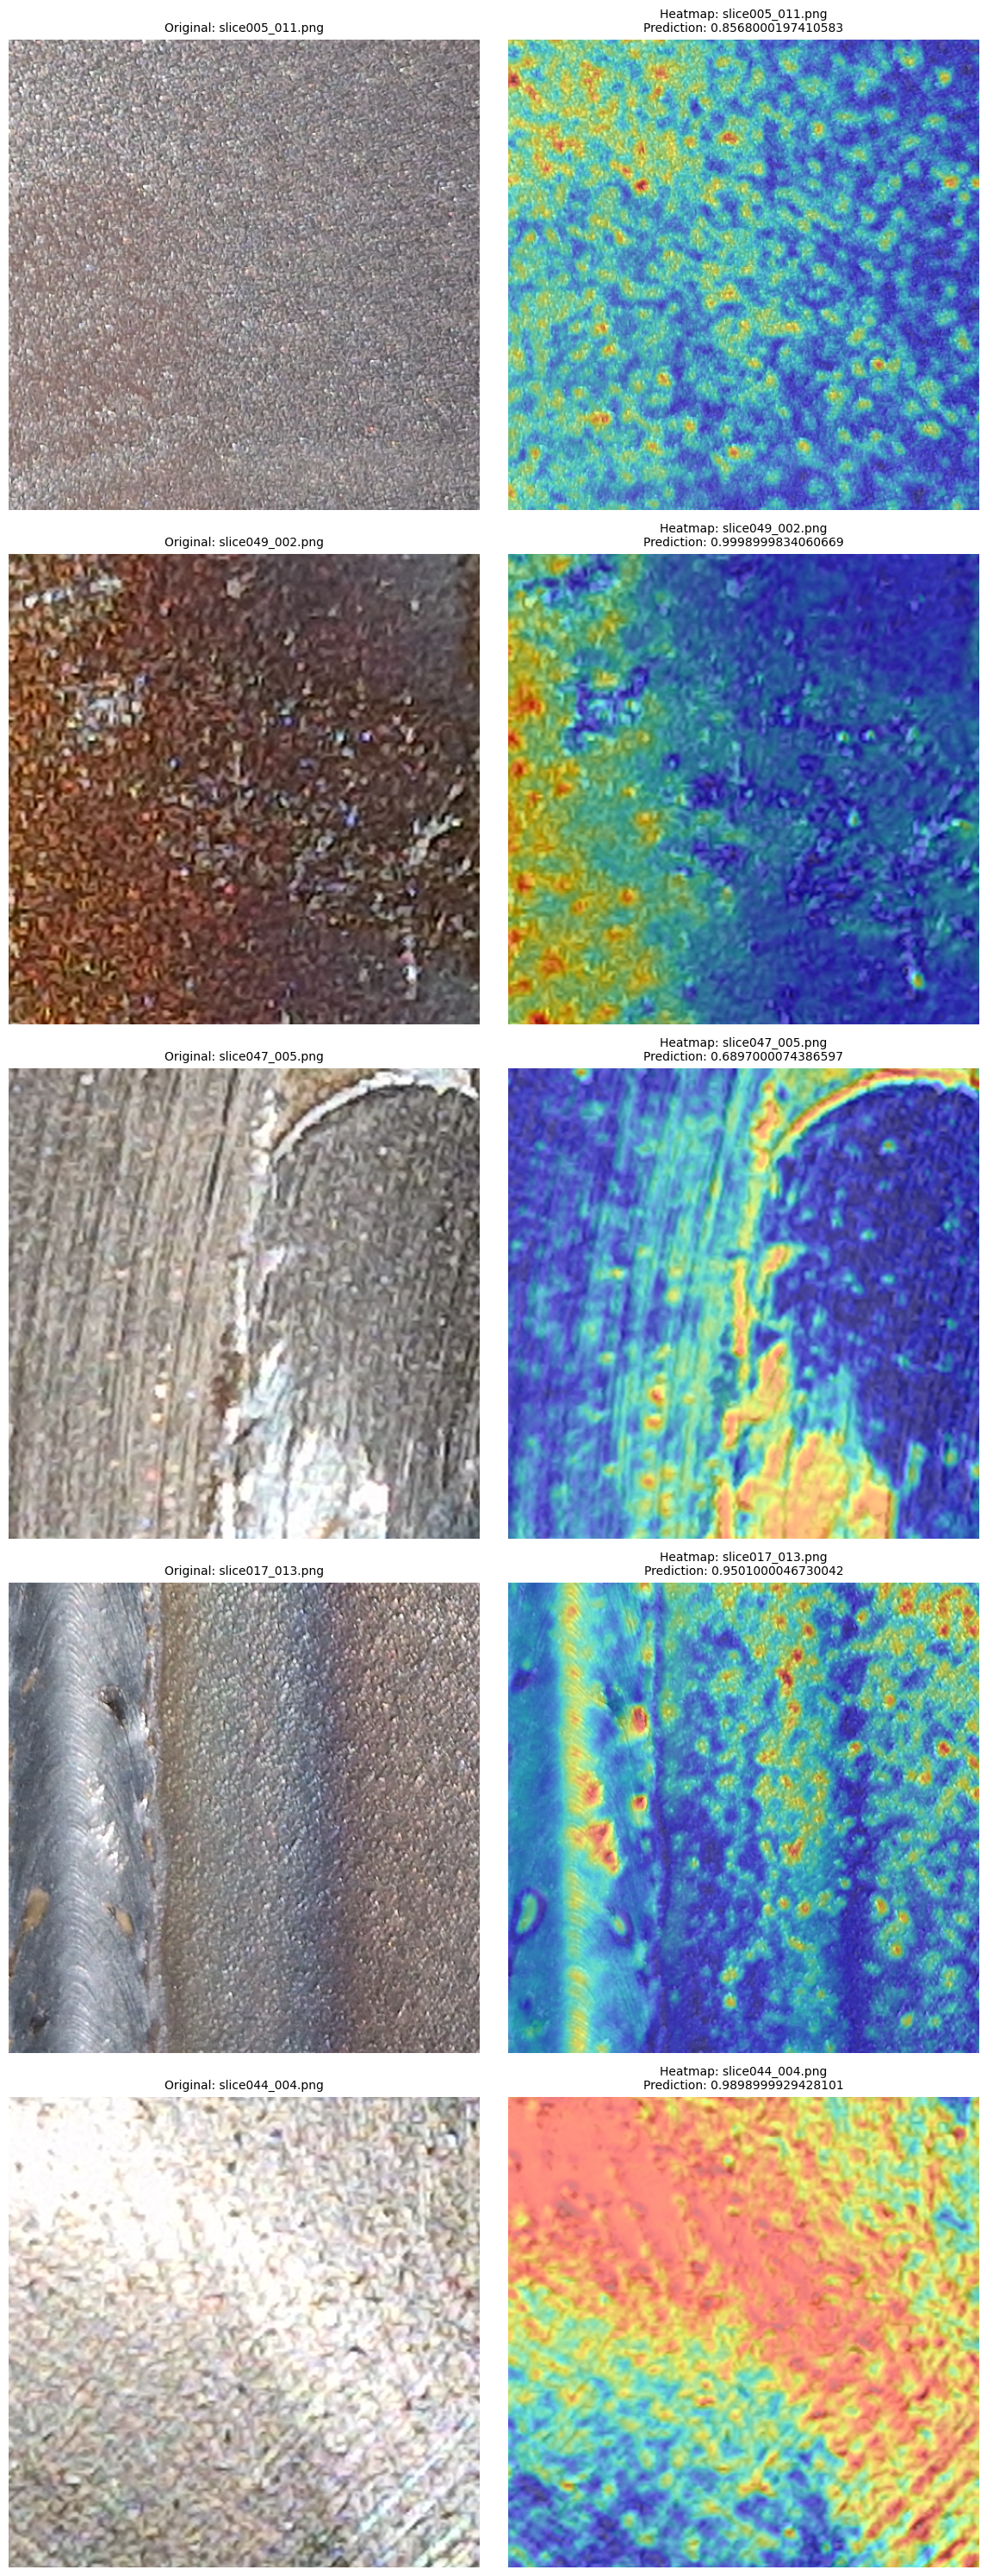

In [13]:
model = load_model(model_path)
model.build(input_shape=(None,512,512,3))

all_images = [f for f in os.listdir(img_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
selected_images = random.sample(all_images, num_pics)


fig, axes = plt.subplots(nrows=num_pics, ncols=2, figsize=(12, num_pics*6))

for idx, img_name in enumerate(selected_images):
    img_path = os.path.join(img_dir, img_name)

    
    img, heatmap_scaled, prediction = do_heatmap(img_path, model, layer_name, dense_layer)

    axes[idx, 0].imshow(img)
    axes[idx, 0].set_title(f"Original: {img_name}", fontsize=10)
    axes[idx, 0].axis('off')

    axes[idx, 1].imshow(img)
    axes[idx, 1].imshow(heatmap_scaled, cmap='jet', alpha=0.5)
    axes[idx, 1].set_title(f"Heatmap: {img_name}\nPrediction: {round(prediction, 4)}", fontsize=10)
    axes[idx, 1].axis('off')

plt.tight_layout()
plt.show()